# ANCOVA for pre/post treatment nonequivalent group designs

:::{note}
This is a preliminary example based on synthetic data. It will hopefully soon be updated with data from a real study.
:::

In cases where there is just one pre and one post treatment measurement, it we can analyse data from {term}`NEGD` experiments using an {term}`ANCOVA` type approach. The basic model is:

$$
post_i = \beta_0 + (\beta_1 \cdot T_i) + (\beta_2 \cdot pre_i) + \epsilon_i
$$

where:

* $i$ represents the $i^{th}$ unit
* $T_i$ is an indicator variable that treatment was assigned to the $i^{th}$ unit.
* $pre_i$ and $post_i$ are the pre and post treatment measurements, respectively.
* $\beta_0$ is an intercept term. Values other than zero indicate change in the untreated group over time.
* $\beta_1$ is the estimated slope of $pre_i$ upon $post_i$, and in many cases we would expect this to be around 1.
* $\epsilon_i$ is the residual. 


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Generate synthetic data

In [3]:
df = cp.load_data("anova1")
df.head()

,group,pre,post
0,0,8.489252,7.824477
1,1,12.419854,14.796265
2,0,11.131001,10.693495
3,0,10.503789,10.532153
4,0,10.599761,9.731500


Let's visualise this data in two different ways.

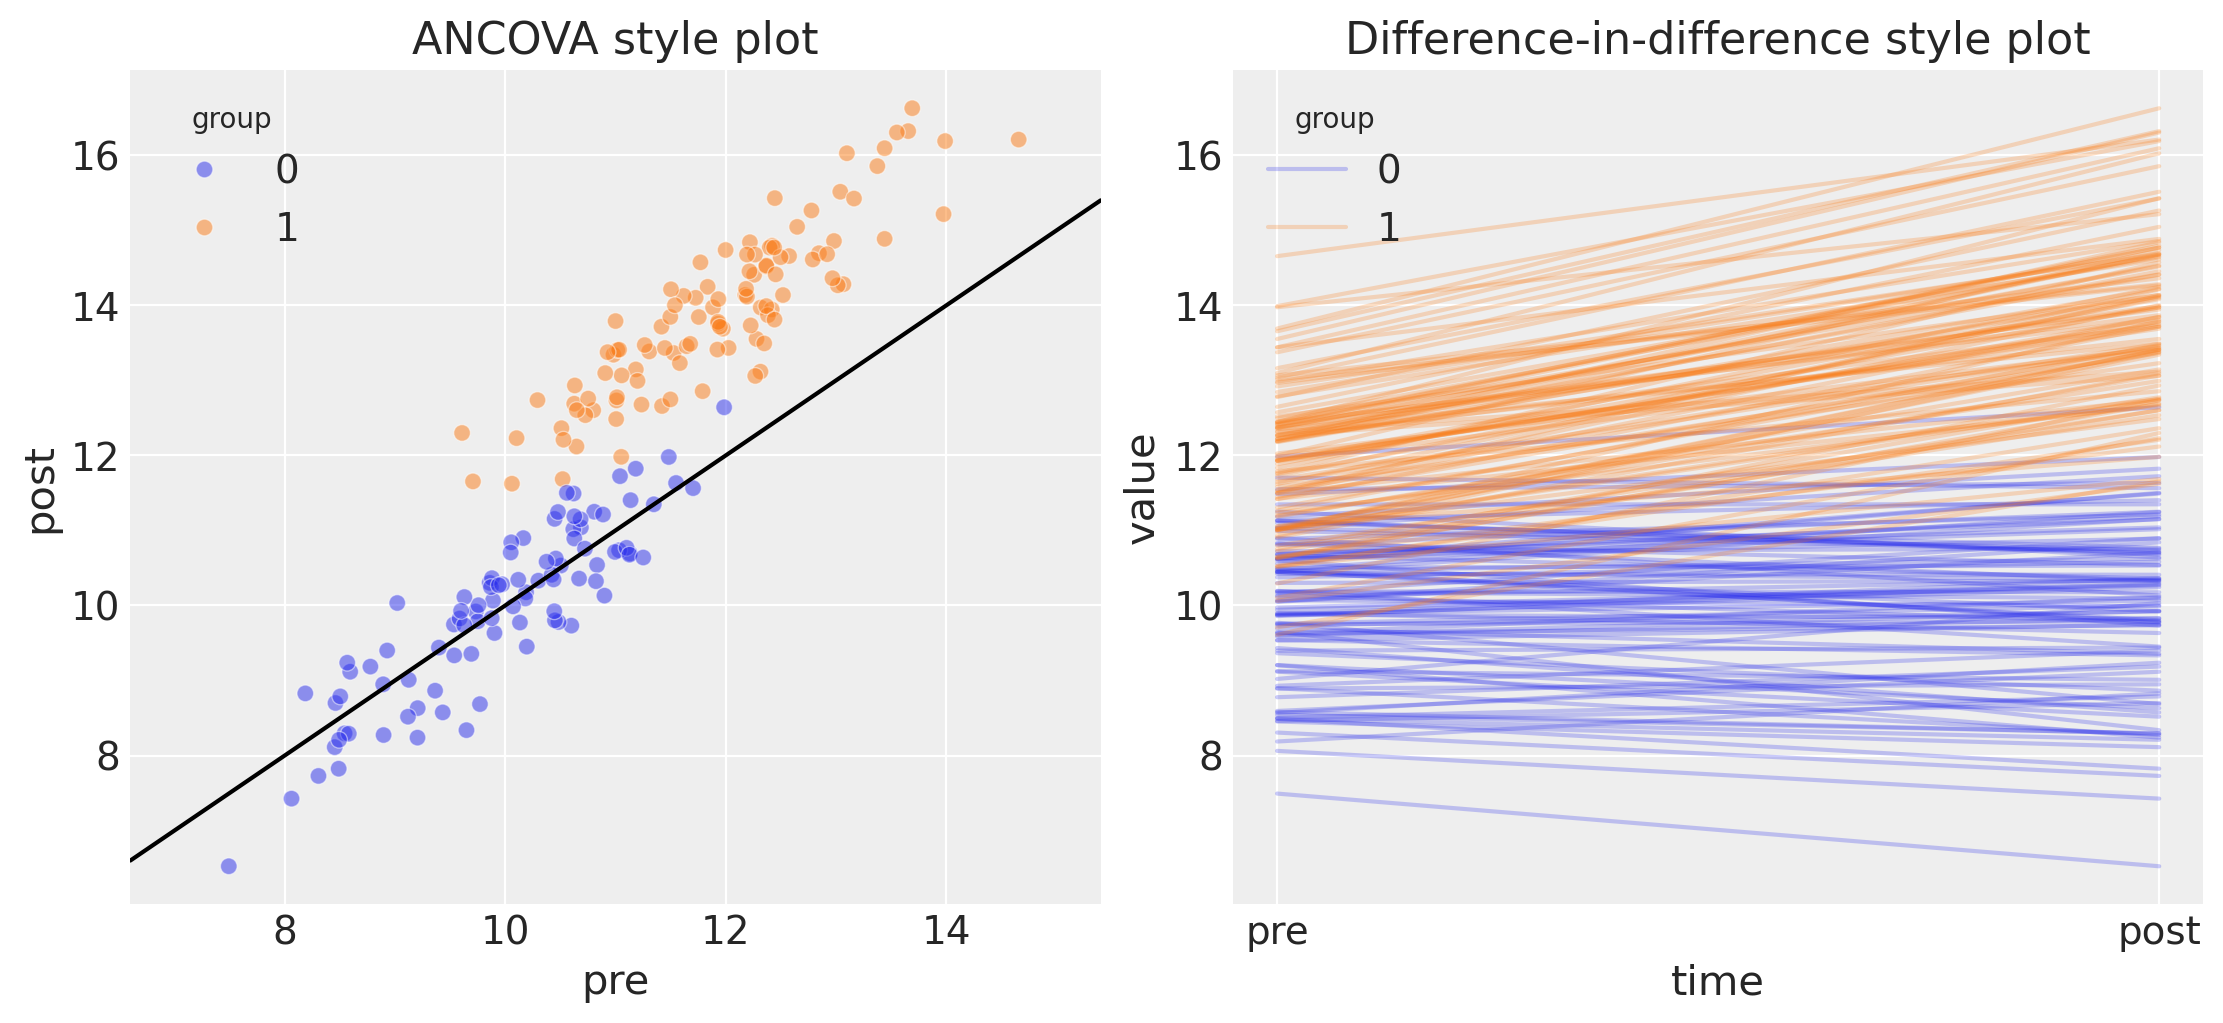

In [4]:
_, ax = plt.subplots(1, 2, figsize=(11, 5))

# ANCOVA plot
ax[0].axline((7, 7), (15, 15), color="k")
sns.scatterplot(x="pre", y="post", hue="group", alpha=0.5, data=df, ax=ax[0])
ax[0].set_title("ANCOVA style plot")

# Difference-in-difference plot
df_did = df.assign(unit=lambda x: x.index).melt(
    id_vars=["group", "unit"], var_name="time", value_name="value"
)
sns.lineplot(
    df_did,
    x="time",
    y="value",
    hue="group",
    units="unit",
    estimator=None,
    alpha=0.25,
    ax=ax[1],
)
ax[1].set_title("Difference-in-difference style plot");

The plot on the left is the most relevant for conducting an ANCOVA style analysis. Pre and post measures are on the x and y axes, respectively. This plot shows a number of things:

* The pre treatment measurement for the control group is lower than for the treatment group, which is consistent with the idea that we have non-random allocation of units to the treatment and control group.
* The control group points lying on the line of unity suggest that the control group was unaffected by the treatment.
* The treatment group scores higher on the post treatment score, shown by the points lying above the line of unity. So visually, we suspect that the treatment caused an increase in the outcome metric.

Of course, many different patterns of result are possible, but we can use the same approach to get a quick visual interpretation of the data.

The plot on the right is of exactly the same data, but plotted in a way which clearly demonstrates the similarity to the difference in differences analysis approach. We don't delve into that more here, but see the difference in difference examples for more on this.

## Run the analysis

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not neccessary. We use it here so that the results are reproducible.
:::

In [5]:
result = cp.PrePostNEGD(
    df,
    formula="post ~ 1 + C(group) + pre",
    group_variable_name="group",
    pretreatment_variable_name="pre",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


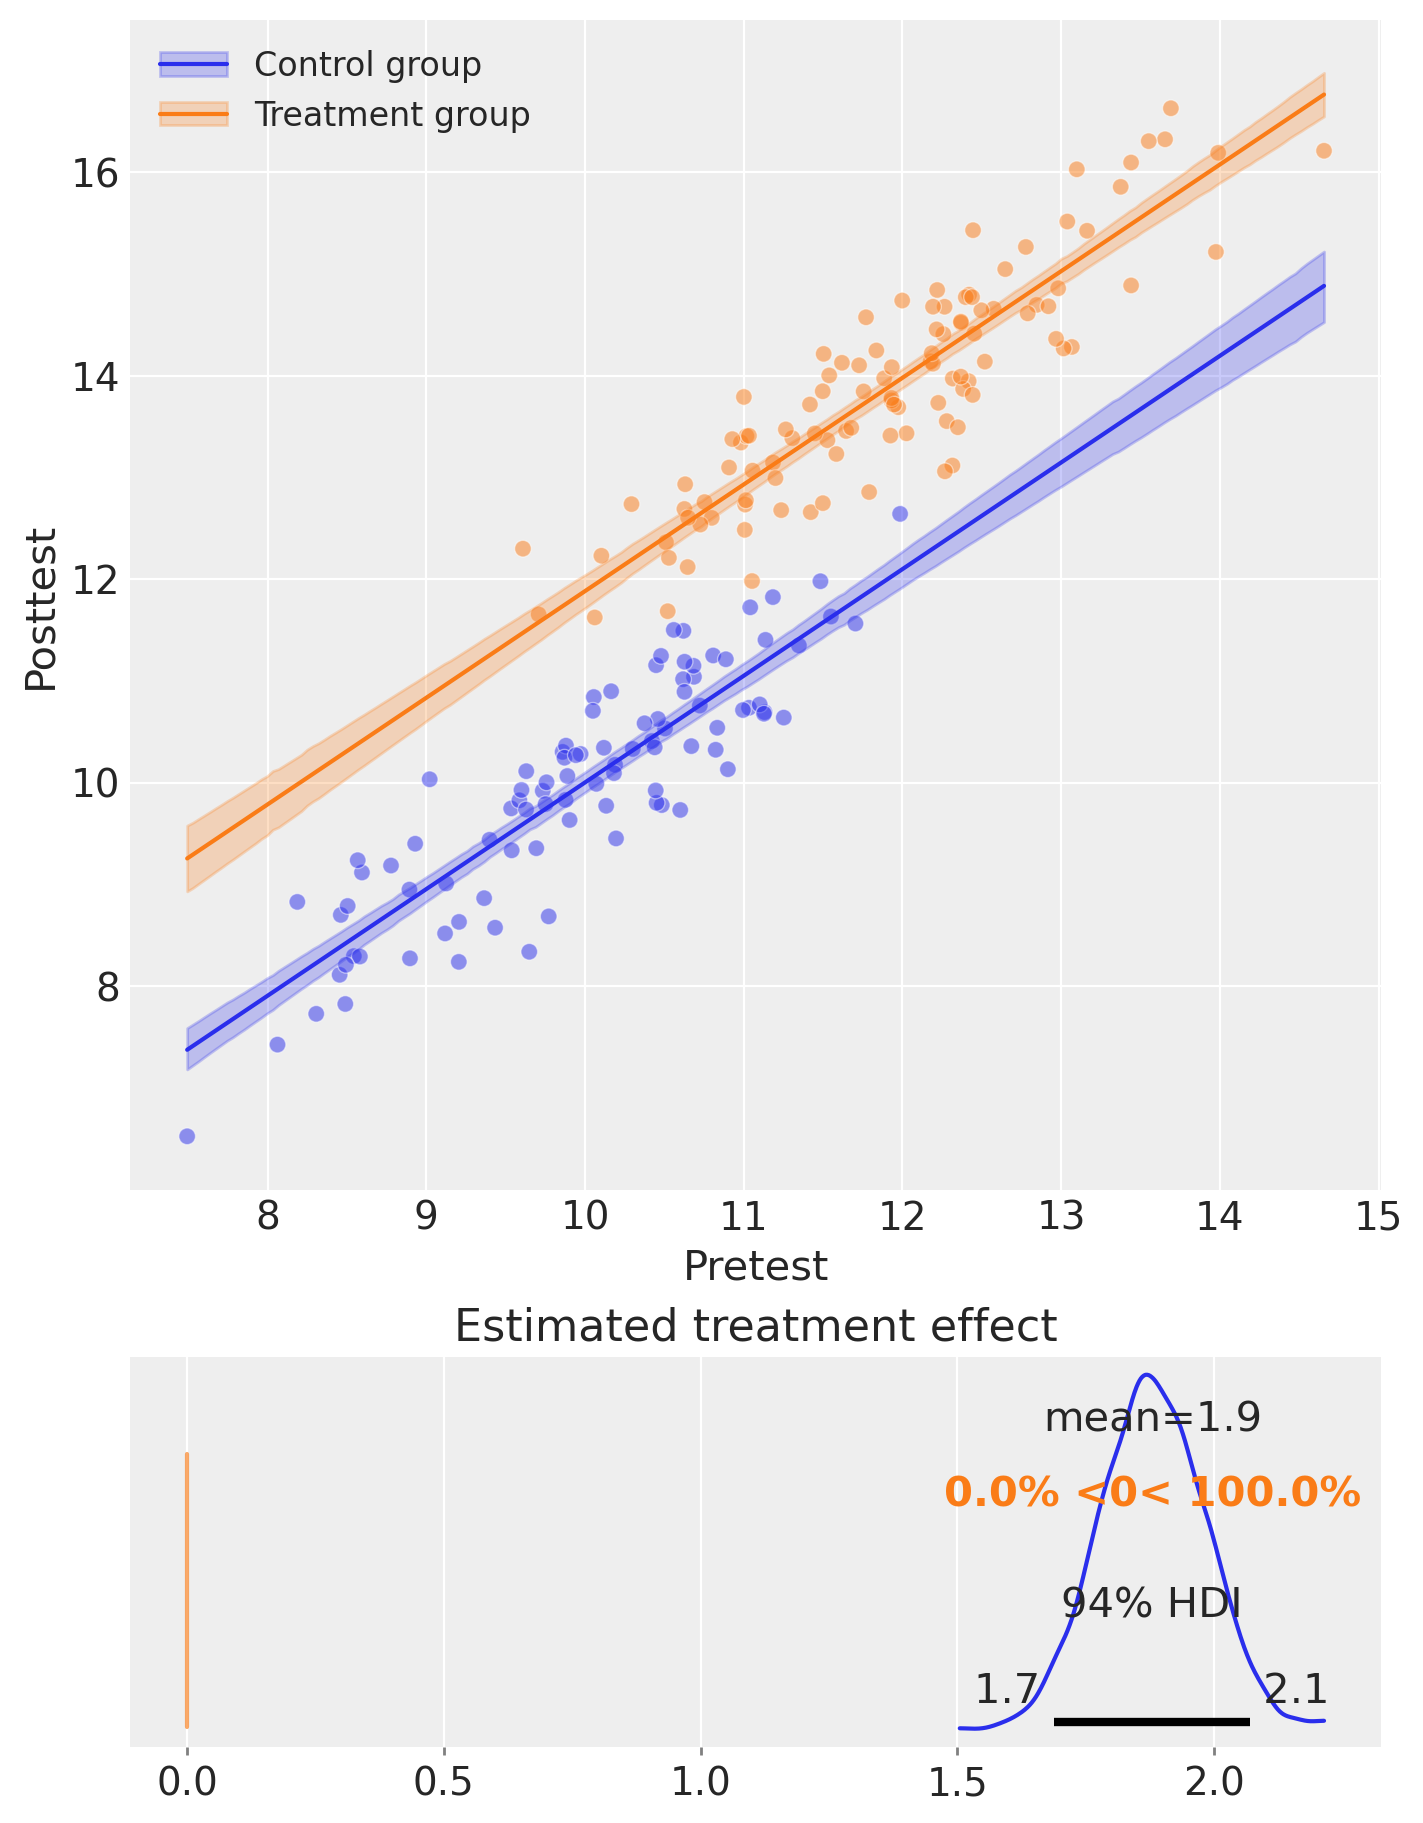

In [6]:
fig, ax = result.plot()

In [7]:
result.summary()

==================Pretest/posttest Nonequivalent Group Design===================
Formula: post ~ 1 + C(group) + pre

Results:
Causal impact = 1.9, $CI_{94%}$[1.7, 2.1]
Model coefficients:
  Intercept    	-0.48, 94% HDI [-1.2, 0.23]
  C(group)[T.1]	1.9, 94% HDI [1.7, 2.1]
  pre          	1, 94% HDI [0.98, 1.1]
  sigma        	0.51, 94% HDI [0.46, 0.56]
